## 钓鱼单历史数据分析

此次工作需要分析找到“乌龙指”。查询乌龙指相关定义为**股票中的“乌龙指”是指股票交易员、操盘手、股民等在交易的时候，不小心敲错了价格、数量、买卖方向等事件的统称,会引起股价的瞬间急剧波动。**

群内给出的例子以及网上查询到的例子有：

- [中证1000期指主力合约IM2211合约一度触及跌停](https://finance.sina.com.cn/money/gzqh/futuresyspzx/2022-11-08/doc-imqmmthc3741398.shtml)： 开盘集合竞价阶段，市场曾出现一次6045.4点位的空头开仓成交，成交手数为83手。随后，9点30分开盘，该合约报价回升至6710点左右。

简单来讲就是产品中异常的接近涨/跌停的幅度变化。因此考虑两个目标:

- DESIRED_1: 超过 10% 的涨跌的数据(和最新价对比)；

- DESIRED_2: 超过 4% 但不足 10% 的涨跌数据；


接下来的任务是需要找到在交易期间的目标数据。参考的数据来自服务器，涵盖2017年至2024年9月的期货tick数据，数据量较大。整体思路如下:

- 确定最小处理单元：以月份作为最小单元，对每一个月份下的数据进行汇总。汇总信息以Log形式保存，要方便读取到所需的乌龙指数据信息。最后的数据处理方法将按月份输出结果。

- 确定数据处理方法：以单个`.txt`文件为例，主要观察字段`last_price`的变化涨跌程度。主要的异常处理为无效的数据、未在开盘时间的数据，计算方法直接通过百分比函数计算得到中间结果即可。随后对得到的中间结果进行遍历，定位找到原始数据中的异常时间点。

- 工程实现：考虑到数据量大，服务器配备的CPU为多核低基频，因此考虑多线程跑程序。不会产生冲突，因为文件的IO都以月份为单元进行输出，不存在冲突问题。

- 最终处理：使用`grep`命令将目录下的所有Log中报Warning的部分重定向到一个新文件，然后在新文件中比对结果校验结果。

In [2]:
import numpy as np
import pandas as pd
import os
import math

DESIRED_1 = 0.1
DESIRED_2 = 0.04

In [3]:
def find_txt_files(directory: str) -> list[str]:
    """
    Find All txt files in required directory.
    """
    txt_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.txt'):
                txt_files.append(os.path.join(root, file))
    return txt_files

def process_month(directory: str, show_progress = True)->None:
    '''
    Find exception values fluctuate in target `dir` (in YYYY/MM/ format). Processing will be done in multi-thread.
    Each thread will saved processed log in `dir` as `output.log`.

    args:
        - `dir`: str, recommended in YYYY/MM level. DO NOT USE YYYY level or DD level dir!!! 
    '''
    txt_files = find_txt_files(directory)
    task_size = len(txt_files)
    fall_count = 0
    import time
    st = time.time()
    if show_progress:
        print(f"[Info] Processing {directory} now!")
    with open(rf"{directory}/output.log",'w') as f :
        for i, pth in enumerate(txt_files):
            # Note : Try to open target file:
            try:
                data = pd.read_csv(pth, sep="|")
                f.writelines(f"[Info] Processing {pth} now ({i + 1}/{task_size})>>>\n")
            except:
                f.writelines(f"[Error] Failed to open {pth}! \n")
                fall_count += 1
                continue
            # Note: Calculate Desired index and record it.
            try:
                req = data['last_price'].pct_change().fillna(0).tolist()
                # del data
                # print("HI")
                for i, sample in enumerate(req):
                    if sample >= 1.:    # 不可能自身马上翻倍，出现这种情况就是时间不对
                        continue
                    elif sample >= DESIRED_1:
                        f.writelines(f"[Warning] Over {DESIRED_1 * 100}% Exception :{sample} Index found in {pth}:{i+1}\n")
                    elif sample >= DESIRED_2:
                        f.writelines(f"[Warning] Over {DESIRED_2 * 100}% Exception :{sample} Index found in {pth}:{i+1}\n")
                    else:
                        continue
                        
            except:
                f.writelines(f"[Error] Cannot Calculate pct_change in {pth}!!!\n")
                fall_count += 1
                continue
        f.writelines(f"\n[Info] All Task Finished. Failed: {fall_count}, Use Time: {time.time() - st} secs.\n")

## Offical Processing

CPU为Intel@ 6226R Golden,有较多的核心但线程数一般。考虑一般处理一个月的数据耗时为15秒，故选择多线程把64个核都吃满来跑。由于CPU本身基频不高，即便有权限设置工作在最高频率也不会有太大提升，因此就是用默认的硬件设置来运行程序即可，预估运行时间为30分钟左右。

In [4]:
import time
import concurrent
tasks = [rf"Tick/{year}/{month}" for year in range(2017,2024) for month in range(1,13)]
t1 = time.time()
with concurrent.futures.ThreadPoolExecutor() as executor:
    # 使用map函数将my_function应用到data的每个元素上
    # map函数会返回一个迭代器，其中包含my_function应用到data每个元素的结果
    results = executor.map(process_month, tasks)
t2 = time.time()
print(rf"ThreadPool Executer using {t2-t1} to process.")

[Info] Processing Tick/2018/2 now!
[Info] Processing Tick/2017/4 now!
[Info] Processing Tick/2017/10 now!
[Info] Processing Tick/2017/1 now!
[Info] Processing Tick/2017/5 now!
[Info] Processing Tick/2017/2 now!
[Info] Processing Tick/2017/7 now!
[Info] Processing Tick/2018/4 now!
[Info] Processing Tick/2017/6 now!
[Info] Processing Tick/2018/12 now!
[Info] Processing Tick/2019/2 now!
[Info] Processing Tick/2018/6 now!
[Info] Processing Tick/2017/11 now!
[Info] Processing Tick/2017/9 now!
[Info] Processing Tick/2017/3 now!
[Info] Processing Tick/2018/10 now!
[Info] Processing Tick/2017/12 now!
[Info] Processing Tick/2018/1 now!
[Info] Processing Tick/2018/7 now!
[Info] Processing Tick/2018/9 now!
[Info] Processing Tick/2018/5 now!
[Info] Processing Tick/2018/8 now!
[Info] Processing Tick/2017/8 now!
[Info] Processing Tick/2019/5 now!
[Info] Processing Tick/2018/3 now!
[Info] Processing Tick/2019/3 now!
[Info] Processing Tick/2019/6 now!
[Info] Processing Tick/2018/11 now!
[Info] Process

## 搜索模块

搜索部分使用`grep` 命令，并把得到的结果输出到一个txt文件中。

bash命令如下：
```bash
#!/bin/bash

# 定义年份和月份范围
YEARS=(2017 2018 2019 2020 2021 2022 2023)
MONTHS=(1 2 3 4 5 6 7 8 9 10 11 12)

# 定义结果文件
RESULT_FILE="result.log"

# 清空结果文件
> $RESULT_FILE

# 遍历年份和月份
for YEAR in "${YEARS[@]}"; do
  for MONTH in "${MONTHS[@]}"; do
    # 构建目录路径
    DIR_PATH="./Tick/${YEAR}/${MONTH}"
    # echo "$YEAR/$MONTH: OMG"
    # 检查目录是否存在
    if [ -d "$DIR_PATH" ]; then
      # 使用grep搜索包含"over"的.log文件，并将结果追加到结果文件中
      grep -inr "over" --include=*.log "$DIR_PATH" >> $RESULT_FILE
    fi
  done
done

# 输出完成信息
echo "搜索完成，结果已保存到 $RESULT_FILE"
```

将其命名为`search.sh`,并赋予操作权限:

```bash
chmod +x search.sh

./search.sh
```

随后根据得到的模块进行校验：

```bash
cat result.log
```
即可跳转到有异常数据点所在的文件中。

## 校验模块

这部分用于对搜索出来的结果进行二次检验。比如说我根据搜索结果，找到2017年3月17日的IC1706有异常情况，那么我可以检验一下是否真的如此：

In [11]:
file = 'Tick/2017/1/23/IC1703.CFFEX.txt'
import pandas as pd 

data = pd.read_csv(file, sep="|")
req= data['last_price'].pct_change().fillna(0).tolist()
print(f"异常出现大致位置：{req.index(max(req))}",f"\nFlucate:{max(req)*100}%")

异常出现大致位置：93 
Flucate:4.3724483076517995%


## 分析！

先来统计下每年发生乌龙指的次数情况，观察乌龙指发生次数的变化：

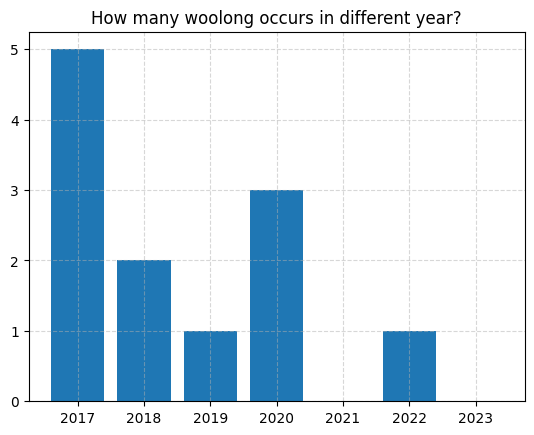

In [8]:
import matplotlib.pyplot as plt

x_data = [i for i in range(2017,2024)]
y_data = [5,2,1,3,0,1,0]
plt.title("How many woolong occurs in different year?")
plt.grid(ls="--", alpha=0.5)
plt.bar(x_data, y_data)
plt.savefig("Num of Woolong per year.jpg")


可以观察到2017-2018年以及2020年的钓鱼单次数出现最多。那么钓鱼单出现的时间有什么特点吗？
通过直接统计可以得到:

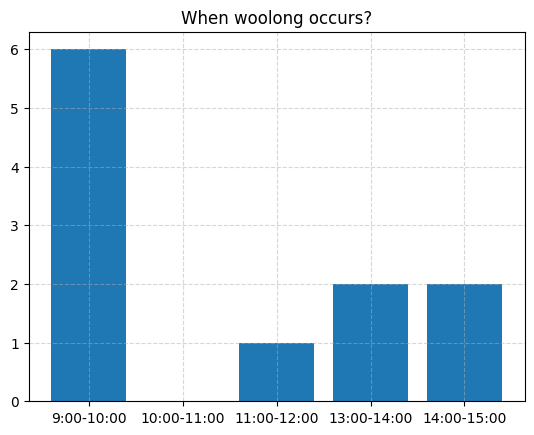

In [10]:
y_data = [6,0,1,2,2,]
x_data = ["9:00-10:00", "10:00-11:00", "11:00-12:00","13:00-14:00","14:00-15:00"]
plt.title("When woolong occurs?")
plt.grid(ls="--", alpha=0.5)
plt.bar(x_data, y_data)
plt.savefig("when woolong occurs?.jpg")

出现乌龙指的时间基本都集中在早上的9:30分左右，因此我们考虑可以在早上9：30分左右或者开盘的时间对期货市场进行监控，看看是否可以构建钓鱼单机会；相对的其他出现乌龙指的时间则比较随机地分布在下午的时间段，没有太明显的规律而言。那么哪些期货最容易出现乌龙指呢?

<BarContainer object of 4 artists>

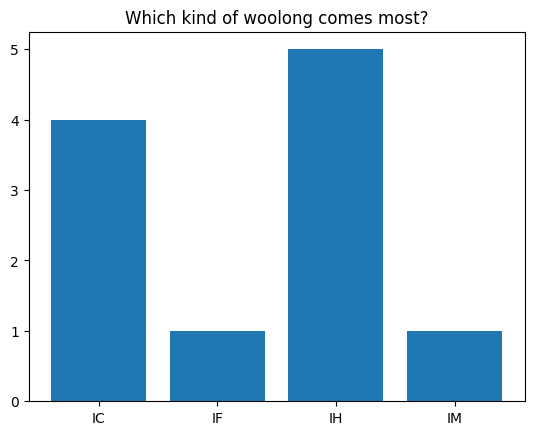

In [32]:
y_data = [5, 1, 4, 1]
x_data = ['IC', "IF", "IH","IM"]
plt.title("Which kind of woolong comes most?")
plt.grid(ls="--", alpha=0.5)
plt.bar(x_data, y_data)

似乎IC和IH相关的期货会出现更多的乌龙指，同时还需要注意，乌龙指很少会（因为我没有以前的数据来对比）出现在同一个期货合约上，因此在钓鱼时考虑选择一些不那么热门的合约进行钓鱼可以增加成功概率。

## 总结

综上所述，根据分析结果来看，乌龙指出现的概率会越来越小，如果考虑要做钓鱼单的话，可以考虑在冷门市场、近年未出现过乌龙指的合约上，于早上开盘或9：30-10：00的时间进行实验，观察是否可以成功钓鱼。最后附上近年来乌龙指的情况：

